# 4. Intersubject Variability

In [2]:
from src import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
from bioinfokit.analys import stat

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from pingouin import ancova

In [1]:
D = lambda x,y: ((x-y)**2).sum(axis=1)

## Description

Compute subset groups of gradients and see how stable the extracted gradients are for each movies. 

GOAL: Evaluate "stability" across subsamples of subjects-generated gradients

## Table of Contents
- [Intersubject Variability Fullmovie vs Rest](#stable)
- [Intersubject Variability Frame Select vs Rest and Fullmovie](#stable)

In [10]:
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

## Intersubject variability Fullmovie vs Rest

##### Generate gradients from subsets of subjects per movie

In [20]:
total_series = load('./data/fmri_414_series.pkl')

all_grads = {mname:  {} for mname in total_series}
for mname in total_series:
    for _id in total_series[mname]:
        tmp_series = total_series[mname][_id]
        fc = FC(tmp_series)
        g = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
        g.fit(fc)
        grad = g.gradients_
        
        fscore = D(grad.mean(axis=0),grad)
        all_grads[mname][_id] = fscore

In [38]:
tmp_grads = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

rest_grads = {}
for _id in tmp_grads:
    grad = tmp_grads[_id]
    fscore = D(grad.mean(axis=0),grad)
    rest_grads[_id] = fscore

all_grads['Rest'] = rest_grads

In [48]:
for mname in total_series:
    print('{} {}'.format(mname,np.asarray(list(all_grads[mname].values())).std(axis=0).mean()))

ToClaireFromSonny 73.32843517718202
TheSecretNumber 79.05860354236911
Chatter 79.3893384200647
LessonLearned 64.29560919202379
Payload 68.69665990411568
AfterTheRain 114.45865185437147
Superhero 124.33116472175658
Sintel 91.08081465766091
TearsOfSteel 83.2014139364806
BetweenViewing 78.24000306534427
BigBuckBunny 150.4308736101909
Rest 120.10230600686569
YouAgain 76.1253626221606
Spaceman 120.86673278738135
FirstBite 68.40935934337219


<AxesSubplot:ylabel='Density'>

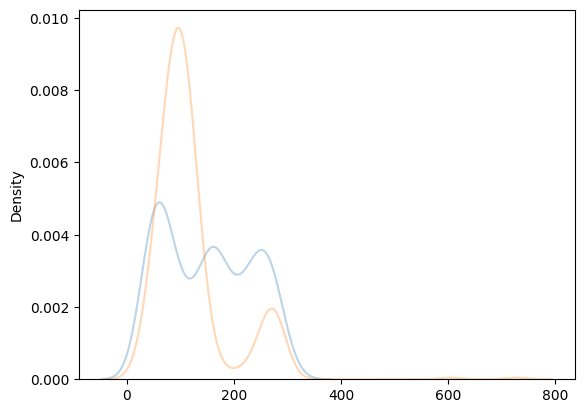

In [51]:
sns.kdeplot(np.asarray(list(all_grads['BigBuckBunny'].values())).std(axis=0), alpha=0.3)
sns.kdeplot(np.asarray(list(all_grads['Rest'].values())).std(axis=0), alpha=0.3)

## Intersubject variability Frame select vs Rest and Fullmovie

##### Generate gradients from subsets of subjects per movie

In [23]:
s5 = [(s,s+5) for s in range(0,101,5) if (s+5 <= 100)]
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

In [46]:
fa_fselect_gradients = load('./resources/fselect_grads/fa_scores_withID/fselected_grads_supermovie_withID.pkl')

In [47]:
fa_fselect_dist = {}
for fa_nb in range(3):
    fa_tmp = fa_fselect_gradients[fa_nb]
    per_fa = {}
    for bound in fa_tmp:
        per_bound = {}
        tmp_grads = fa_tmp[bound]
        for _id in tmp_grads:
            dist = D(tmp_grads[_id].mean(axis=0),tmp_grads[_id])
            per_bound[_id] = dist

        per_fa[bound] = per_bound
    fa_fselect_dist[fa_nb] = per_fa

Keeping the FA we want to display and adding in the dists from other contexts

In [99]:
all_grads = deepcopy(fa_fselect_dist[0])

In [100]:
tmp_grads = load('./resources/static_grad/individual_level/Rest_grad414.pkl')

rest_grads = {}
for _id in tmp_grads:
    grad = tmp_grads[_id]
    fscore = D(grad.mean(axis=0),grad)
    rest_grads[_id] = fscore

all_grads['Rest'] = rest_grads

tmp_grads = load('./resources/static_grad/individual_level/SUPERMOVIE_grad414.pkl')

fmovie_grads = {}
for _id in tmp_grads:
    grad = tmp_grads[_id]
    fscore = D(grad.mean(axis=0),grad)
    fmovie_grads[_id] = fscore

all_grads['Movie'] = fmovie_grads

In [111]:
tmp_grads = load('./resources/null_grad/sample_bins/nulldistrib_random5.pkl')

bound = (20,25)
random_grads = []
for nb in range(len(tmp_grads)):
    tmp_dists = []
    for k in range(30):
        grad = tmp_grads[nb][bound][k]
        fscore = D(grad.mean(axis=0),grad)
        tmp_dists.append(fscore)
    random_grads.append(tmp_dists)
    
median_random = np.percentile(np.asarray(random_grads).std(axis=1).mean(axis=1),50)

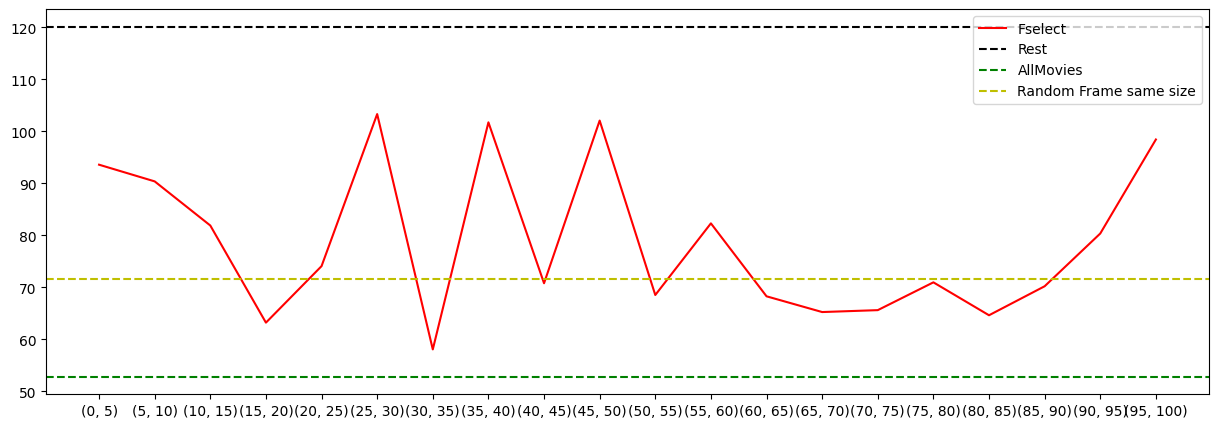

In [116]:
fig,ax = plt.subplots(figsize=(15,5))
scores1 = [np.asarray(list(all_grads[bound].values())).std(axis=0).mean() for bound in s5]
rest_score = np.asarray(list(all_grads['Rest'].values())).std(axis=0).mean()
movie_score = np.asarray(list(all_grads['Movie'].values())).std(axis=0).mean()

ax.plot(scores1, color='r', label='Fselect')
ax.axhline(y=rest_score, color='k', linestyle='--', label='Rest')
ax.axhline(y=movie_score, color='g', linestyle='--', label='AllMovies')
ax.axhline(y=median_random, color='y', linestyle='--', label='Random Frame same size')

ax.set_xticklabels([str(b) for b in s5])
ax.set_xticks(np.arange(0,len(s5)))
plt.legend()